### The below notebook analyzes the uber fare data for each trip & predicts the uber fare 

In [2]:
#import libraries
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import datetime
#from geopy.geocoders import Nominatim
#import plotly.express as px
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

In [3]:
#create a function for distance calculation between the two locations latitudes and logitudes
from math import radians, cos, sin, asin, sqrt
def calculate_distance(lat1, lat2, lon1, lon2):
	
	# The math module contains a function named
	# radians which converts from degrees to radians.
	lon1 = radians(lon1)
	lon2 = radians(lon2)
	lat1 = radians(lat1)
	lat2 = radians(lat2)
	
	# Haversine formula
	dlon = lon2 - lon1
	dlat = lat2 - lat1
	a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2

	c = 2 * asin(sqrt(a))
	
	# Radius of earth in kilometers. Use 3956 for miles
	r = 6371
	
	# calculate the result
	return(c * r)
	
	


In [4]:
#read the data 
uber_fare_df= pd.read_csv('../input/uber-fares-dataset/uber.csv')

In [5]:
uber_fare_df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [6]:
uber_fare_df.columns

Index(['Unnamed: 0', 'key', 'fare_amount', 'pickup_datetime',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count'],
      dtype='object')

In [7]:
uber_fare_df_1= uber_fare_df.drop(['Unnamed: 0','key'],axis=1) # key and Unnamed ID seems to have no impact on our study


In [8]:
#study how many missing data are there ?
uber_fare_df_1.isnull().sum()

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

In [9]:
#since there are 2 values which are missing , we can remove it ....
uber_fare_df_1.dropna(axis=0,inplace=True)

In [10]:
uber_fare_df_1

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5
...,...,...,...,...,...,...,...
199995,3.0,2012-10-28 10:49:00 UTC,-73.987042,40.739367,-73.986525,40.740297,1
199996,7.5,2014-03-14 01:09:00 UTC,-73.984722,40.736837,-74.006672,40.739620,1
199997,30.9,2009-06-29 00:42:00 UTC,-73.986017,40.756487,-73.858957,40.692588,2
199998,14.5,2015-05-20 14:56:25 UTC,-73.997124,40.725452,-73.983215,40.695415,1


In [11]:
#splitting up the date (pickup date) to extract meaningful datas

#extract the time out of date and bin it to the morning, afternoon, evening, night
uber_fare_df_1['pickup_datetime'] = pd.to_datetime(uber_fare_df_1.pickup_datetime,utc=True)

In [12]:
uber_fare_df_1['pickup_timehour']= uber_fare_df_1['pickup_datetime'].apply(lambda x: x.hour)
uber_fare_df_1['Day']= uber_fare_df_1['pickup_datetime'].dt.day_name()
uber_fare_df_1['Day Part']= pd.cut(uber_fare_df_1['pickup_timehour'],bins=[-1,4,12,17,21,23],labels=['Night','Morning','Afternoon','Evening','Night'],ordered=False)
uber_fare_df_1['pickup_month']= uber_fare_df_1['pickup_datetime'].apply(lambda x: x.month)
uber_fare_df_1['pickup_year']= uber_fare_df_1['pickup_datetime'].apply(lambda x: x.year)
uber_fare_df_1['distance_travelled (KM)']= uber_fare_df_1.apply(lambda x: calculate_distance(x['pickup_latitude'],x['dropoff_latitude'],x['pickup_longitude'],x['dropoff_longitude']),axis=1)


In [13]:
uber_fare_df_1

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_timehour,Day,Day Part,pickup_month,pickup_year,distance_travelled (KM)
0,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,19,Thursday,Evening,5,2015,1.683323
1,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,20,Friday,Evening,7,2009,2.457590
2,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,21,Monday,Evening,8,2009,5.036377
3,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,8,Friday,Morning,6,2009,1.661683
4,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,17,Thursday,Afternoon,8,2014,4.475450
...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,3.0,2012-10-28 10:49:00+00:00,-73.987042,40.739367,-73.986525,40.740297,1,10,Sunday,Morning,10,2012,0.112210
199996,7.5,2014-03-14 01:09:00+00:00,-73.984722,40.736837,-74.006672,40.739620,1,1,Friday,Night,3,2014,1.875050
199997,30.9,2009-06-29 00:42:00+00:00,-73.986017,40.756487,-73.858957,40.692588,2,0,Monday,Night,6,2009,12.850319
199998,14.5,2015-05-20 14:56:25+00:00,-73.997124,40.725452,-73.983215,40.695415,1,14,Wednesday,Afternoon,5,2015,3.539715


### Exploratory Data Analysis (EDA)

In [14]:
uber_fare_df_1.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_timehour,pickup_month,pickup_year,distance_travelled (KM)
count,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000
mean,11.359892,-72.527631,39.935881,-72.525292,39.923890,1.684543,13.491387,6.281791,2011.742434,20.855350
std,9.901760,11.437815,7.720558,13.117408,6.794829,1.385995,6.515505,3.438933,1.856400,382.964642
min,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000,0.000000,1.000000,2009.000000,0.000000
25%,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.000000,9.000000,3.000000,2010.000000,1.215222
50%,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000,14.000000,6.000000,2012.000000,2.120992
75%,12.500000,-73.967154,40.767158,-73.963658,40.768001,2.000000,19.000000,9.000000,2013.000000,3.875169
max,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000,23.000000,12.000000,2015.000000,16409.239135


In [15]:
#here we can see some data are not real in case ---------------- Final decision

### fare cannot be negative (put the data in test )

### passenger count is not zero (first remove it and study again using that)

#latitude and longitude should not be zero (because location is in middle of Atlantic Ocean, so need to drop all the values )


In [16]:
outlier_data= uber_fare_df_1[(uber_fare_df_1['fare_amount']<=0)|(uber_fare_df_1['passenger_count']==0)|(uber_fare_df_1['pickup_latitude']==0.000000)]

In [17]:
# checking the fare amount =0
outlier_data[outlier_data['fare_amount']<=0]

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_timehour,Day,Day Part,pickup_month,pickup_year,distance_travelled (KM)
20744,0.00,2015-04-22 23:25:07+00:00,-73.658897,40.805199,-73.658897,40.805199,1,23,Wednesday,Night,4,2015,0.000000
22182,0.00,2010-03-20 02:59:51+00:00,-73.994366,40.755395,-73.998718,40.854853,2,2,Saturday,Night,3,2010,11.065289
63395,-5.00,2015-03-03 23:07:41+00:00,-73.992249,40.748936,-73.988518,40.748180,1,23,Tuesday,Night,3,2015,0.325306
71246,-3.30,2010-02-11 21:47:10+00:00,-73.952725,40.768235,-73.949928,40.772208,2,21,Thursday,Evening,2,2010,0.500646
79903,-3.50,2015-05-01 14:43:02+00:00,-73.982430,40.775024,-73.981750,40.778439,1,14,Friday,Afternoon,5,2015,0.383918
87467,0.00,2015-01-04 03:51:13+00:00,-73.969475,40.807503,0.000000,0.000000,2,3,Sunday,Night,1,2015,8665.983754
89322,-49.57,2010-03-09 08:26:10+00:00,-73.972772,40.785657,-73.972867,40.785500,5,8,Tuesday,Morning,3,2010,0.019203
92063,-23.70,2010-03-12 08:49:10+00:00,-73.952740,40.768233,-74.007028,40.707338,3,8,Friday,Morning,3,2010,8.171296
98875,-52.00,2015-03-20 21:31:14+00:00,-74.000359,40.728729,-74.005699,40.728680,5,21,Friday,Evening,3,2015,0.450054
104080,-7.30,2010-03-09 20:25:10+00:00,-73.952623,40.766942,-73.953787,40.784882,1,20,Tuesday,Evening,3,2010,1.997243


In [18]:
outlier_data[(outlier_data['pickup_latitude']==0.000000)&(outlier_data['pickup_longitude']==0.000000)]

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_timehour,Day,Day Part,pickup_month,pickup_year,distance_travelled (KM)
7,2.5,2012-12-11 13:52:00+00:00,0.0,0.0,0.0,0.0,1,13,Tuesday,Afternoon,12,2012,0.0
11,8.5,2011-05-23 22:15:00+00:00,0.0,0.0,0.0,0.0,1,22,Monday,Night,5,2011,0.0
65,6.0,2014-05-05 19:27:00+00:00,0.0,0.0,0.0,0.0,1,19,Monday,Evening,5,2014,0.0
92,6.1,2011-12-02 14:07:00+00:00,0.0,0.0,0.0,0.0,1,14,Friday,Afternoon,12,2011,0.0
120,6.5,2010-08-20 19:39:48+00:00,0.0,0.0,0.0,0.0,1,19,Friday,Evening,8,2010,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
199718,4.9,2011-08-19 07:16:00+00:00,0.0,0.0,0.0,0.0,1,7,Friday,Morning,8,2011,0.0
199724,7.5,2013-10-11 11:25:41+00:00,0.0,0.0,0.0,0.0,1,11,Friday,Morning,10,2013,0.0
199880,6.5,2014-02-22 06:45:46+00:00,0.0,0.0,0.0,0.0,1,6,Saturday,Morning,2,2014,0.0
199883,12.5,2012-09-10 17:39:00+00:00,0.0,0.0,0.0,0.0,2,17,Monday,Afternoon,9,2012,0.0


<AxesSubplot:xlabel='dropoff_latitude', ylabel='Count'>

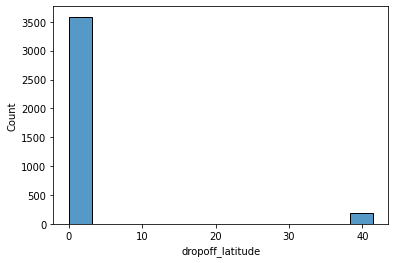

In [19]:
#distribution of latitude for the outlier data where lattitude==0 and longitude==0
sb.histplot(outlier_data[(outlier_data['pickup_latitude']==0.000000)&(outlier_data['pickup_longitude']==0.000000)]['dropoff_latitude'])

<AxesSubplot:xlabel='fare_amount', ylabel='Count'>

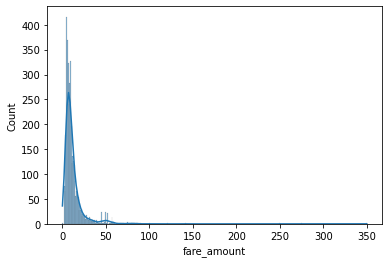

In [20]:
sb.histplot(outlier_data[(outlier_data['pickup_latitude']==0.000000)&(outlier_data['pickup_longitude']==0.000000)]['fare_amount'],kde=True)

In [21]:
outlier_data[outlier_data['passenger_count']==0]

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_timehour,Day,Day Part,pickup_month,pickup_year,distance_travelled (KM)
333,10.1,2011-08-05 07:03:08+00:00,-74.013900,40.707800,-73.992300,40.749300,0,7,Friday,Morning,8,2011,4.960570
908,11.7,2011-09-06 12:25:19+00:00,-73.981000,40.764600,-73.962900,40.778400,0,12,Tuesday,Morning,9,2011,2.162835
926,3.3,2012-03-26 18:11:24+00:00,-73.979978,40.765821,-73.983894,40.766873,0,18,Monday,Evening,3,2012,0.349924
2000,15.7,2012-04-20 15:07:57+00:00,-73.975285,40.750138,-73.974729,40.783151,0,15,Friday,Afternoon,4,2012,3.671177
3011,6.1,2012-01-07 19:19:08+00:00,-73.977900,40.789100,-73.983700,40.773600,0,19,Saturday,Evening,1,2012,1.791370
...,...,...,...,...,...,...,...,...,...,...,...,...,...
196797,3.3,2011-01-17 15:52:26+00:00,-74.000760,40.757637,-74.004852,40.751947,0,15,Monday,Afternoon,1,2011,0.720492
197103,7.3,2011-12-10 15:33:12+00:00,0.000000,0.000000,0.000000,0.000000,0,15,Saturday,Afternoon,12,2011,0.000000
198872,5.7,2011-09-20 19:55:05+00:00,-73.980300,40.742800,-73.967900,40.755600,0,19,Tuesday,Evening,9,2011,1.765465
198902,12.1,2011-08-22 21:10:56+00:00,-73.996700,40.737200,-74.008500,40.704000,0,21,Monday,Evening,8,2011,3.823264


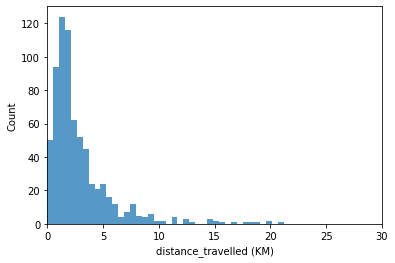

In [22]:
### study the distribution of distance travelled

sb.histplot(outlier_data[outlier_data['passenger_count']==0]['distance_travelled (KM)'])

plt.xlim(0,30)
plt.show()

In [23]:
print(f'Before dropping {uber_fare_df_1.shape}')

Before dropping (199999, 13)


In [24]:
#remove the data 
#remove the latitude and longitude ===000, passenger_count=0, fare<=0

uber_fare_df_1=uber_fare_df_1[~((uber_fare_df_1['pickup_latitude']==0.000000)&(uber_fare_df_1['pickup_longitude']==0.000000))]
print(f'After dropping the data, the final shape is {uber_fare_df_1.shape}')

After dropping the data, the final shape is (196220, 13)


In [25]:
199999-196220

3779

In [26]:
uber_fare_df_1=uber_fare_df_1[~(uber_fare_df_1['fare_amount']<=0)]
uber_fare_df_1=uber_fare_df_1[~(uber_fare_df_1['passenger_count']==0)]
print(f'After dropping the data, the final shape is {uber_fare_df_1.shape}')

After dropping the data, the final shape is (195511, 13)


In [27]:
uber_fare_df_1=uber_fare_df_1[~(uber_fare_df_1['passenger_count']==208)]
print(f'After dropping the data, the final shape is {uber_fare_df_1.shape}')

After dropping the data, the final shape is (195510, 13)


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='distance_travelled (KM)'>

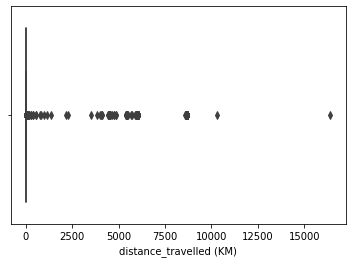

In [28]:
sb.boxplot(uber_fare_df_1['distance_travelled (KM)'])

In [29]:
#let's put a threshold for distance above 500 km as not possible
uber_fare_df_1= uber_fare_df_1[uber_fare_df_1['distance_travelled (KM)']<=50]
print(f'After dropping the data, the final shape is {uber_fare_df_1.shape}')


After dropping the data, the final shape is (195209, 13)


In [30]:
196220-195511

709

In [31]:
uber_fare_df_1.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_timehour,pickup_month,pickup_year,distance_travelled (KM)
count,195209.000000,195209.000000,195209.000000,195209.000000,195209.000000,195209.000000,195209.000000,195209.000000,195209.000000,195209.000000
mean,11.347863,-73.908822,40.689697,-73.907851,40.688160,1.690107,13.491325,6.284321,2011.741221,3.316620
std,9.773993,2.710281,2.768826,2.710367,2.646280,1.306062,6.515514,3.439510,1.861764,3.594855
min,0.010000,-75.387785,-74.015515,-75.417737,-74.015750,1.000000,0.000000,1.000000,2009.000000,0.000000
25%,6.000000,-73.992269,40.736397,-73.991594,40.735279,1.000000,9.000000,3.000000,2010.000000,1.255272
50%,8.500000,-73.982104,40.753275,-73.980526,40.753723,1.000000,14.000000,6.000000,2012.000000,2.156107
75%,12.500000,-73.968331,40.767532,-73.965332,40.768317,2.000000,19.000000,9.000000,2013.000000,3.906828
max,499.000000,40.808425,401.066667,40.831932,45.031598,6.000000,23.000000,12.000000,2015.000000,49.003731


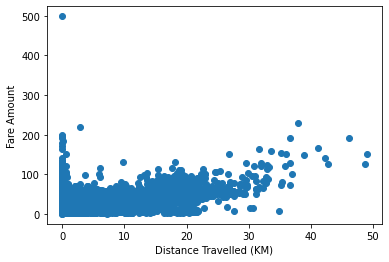

In [32]:
plt.scatter(uber_fare_df_1['distance_travelled (KM)'],uber_fare_df_1['fare_amount'])
plt.xlabel('Distance Travelled (KM)')
plt.ylabel('Fare Amount')
plt.show()


In [33]:
uber_fare_df_1

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_timehour,Day,Day Part,pickup_month,pickup_year,distance_travelled (KM)
0,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,19,Thursday,Evening,5,2015,1.683323
1,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,20,Friday,Evening,7,2009,2.457590
2,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,21,Monday,Evening,8,2009,5.036377
3,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,8,Friday,Morning,6,2009,1.661683
4,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,17,Thursday,Afternoon,8,2014,4.475450
...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,3.0,2012-10-28 10:49:00+00:00,-73.987042,40.739367,-73.986525,40.740297,1,10,Sunday,Morning,10,2012,0.112210
199996,7.5,2014-03-14 01:09:00+00:00,-73.984722,40.736837,-74.006672,40.739620,1,1,Friday,Night,3,2014,1.875050
199997,30.9,2009-06-29 00:42:00+00:00,-73.986017,40.756487,-73.858957,40.692588,2,0,Monday,Night,6,2009,12.850319
199998,14.5,2015-05-20 14:56:25+00:00,-73.997124,40.725452,-73.983215,40.695415,1,14,Wednesday,Afternoon,5,2015,3.539715


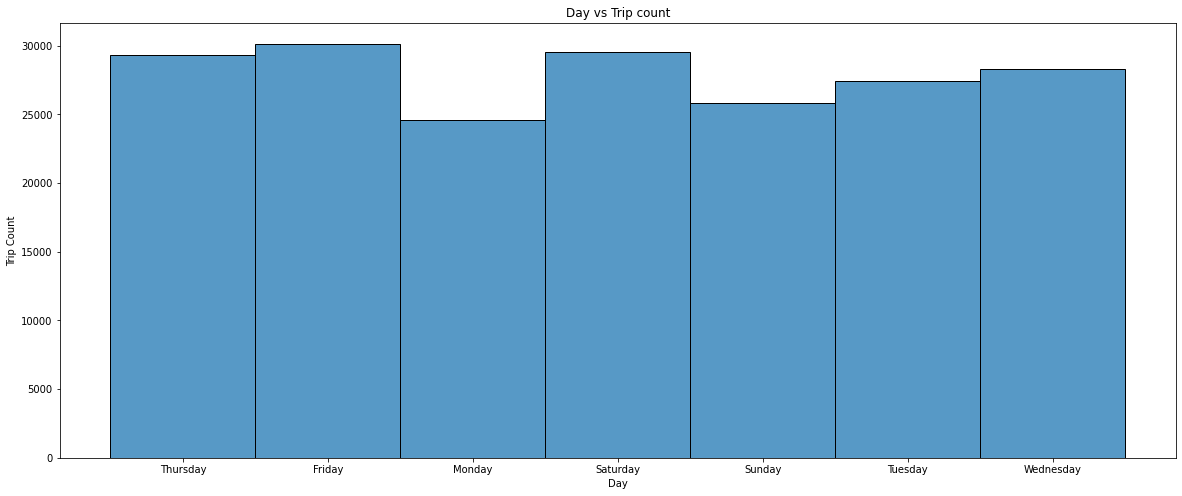

In [34]:
#study how much fare for each day in different parts of day 
plt.figure(figsize=(20,8))
sb.histplot(uber_fare_df_1['Day'])
plt.ylabel('Trip Count')
plt.title('Day vs Trip count')
plt.show()

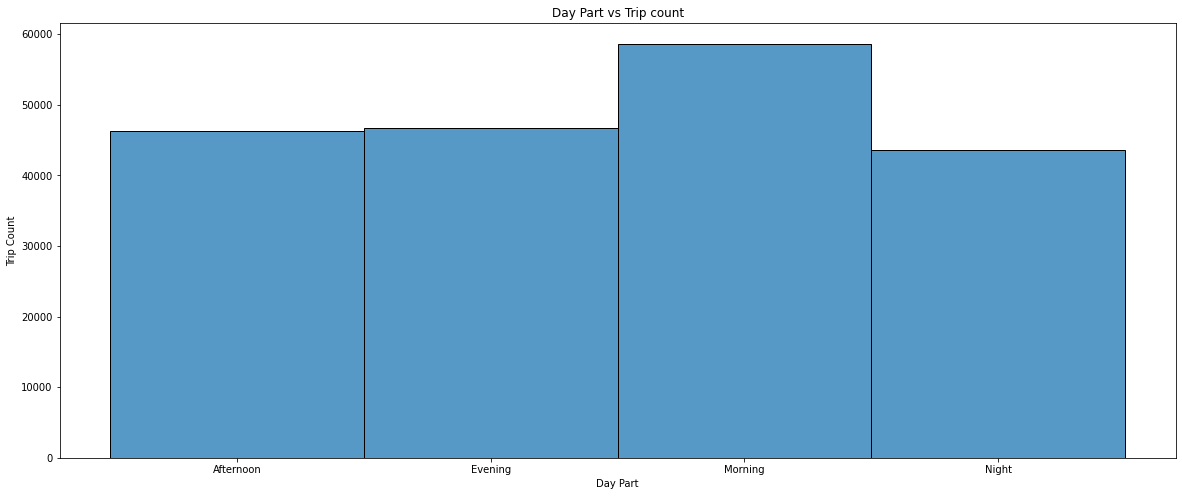

In [35]:
#study how much fare for each day in different parts of day 
plt.figure(figsize=(20,8))
sb.histplot(uber_fare_df_1['Day Part'])
plt.ylabel('Trip Count')
plt.title('Day Part vs Trip count')
plt.show()

In [36]:
uber_fare_df_1.columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
       'pickup_timehour', 'Day', 'Day Part', 'pickup_month', 'pickup_year',
       'distance_travelled (KM)'],
      dtype='object')

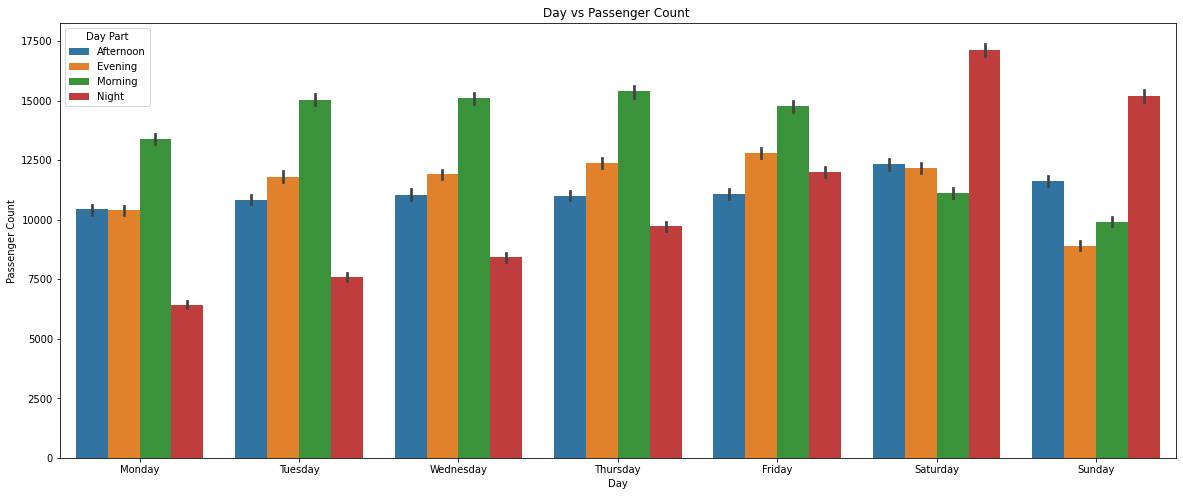

In [37]:
#study how much passenger (in mean) for each day in different parts of day 
plt.figure(figsize=(20,8))
sb.barplot(x=uber_fare_df_1['Day'],y=uber_fare_df_1['passenger_count'],hue=uber_fare_df_1['Day Part'],order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],estimator=sum)
plt.ylabel('Passenger Count')
plt.title('Day vs Passenger Count ')
plt.show()

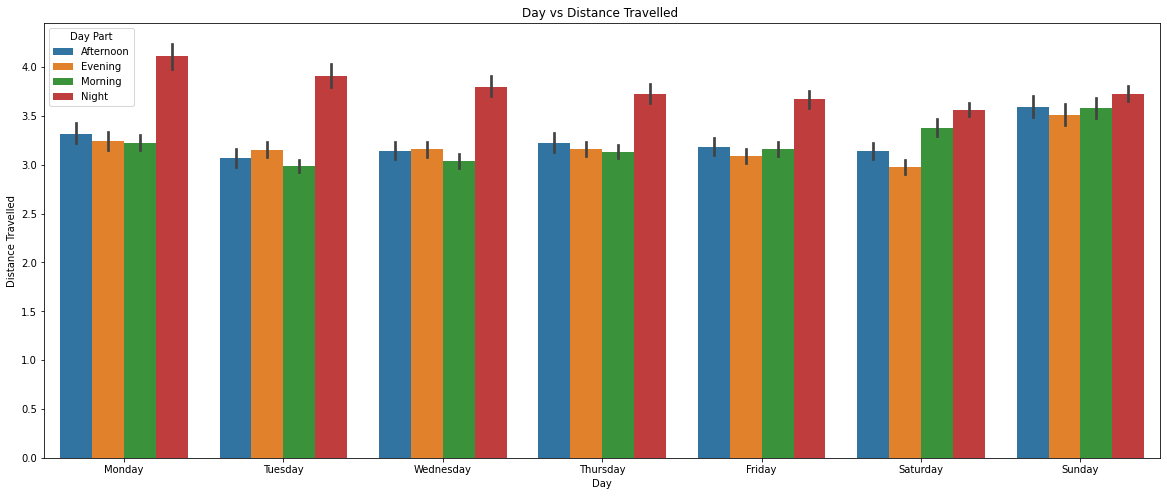

In [38]:
#study how much passenger (in mean) for each day in different parts of day 
plt.figure(figsize=(20,8))
sb.barplot(x=uber_fare_df_1['Day'],y=uber_fare_df_1['distance_travelled (KM)'],hue=uber_fare_df_1['Day Part'],order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.ylabel('Distance Travelled')
plt.title('Day vs Distance Travelled ')
plt.show()

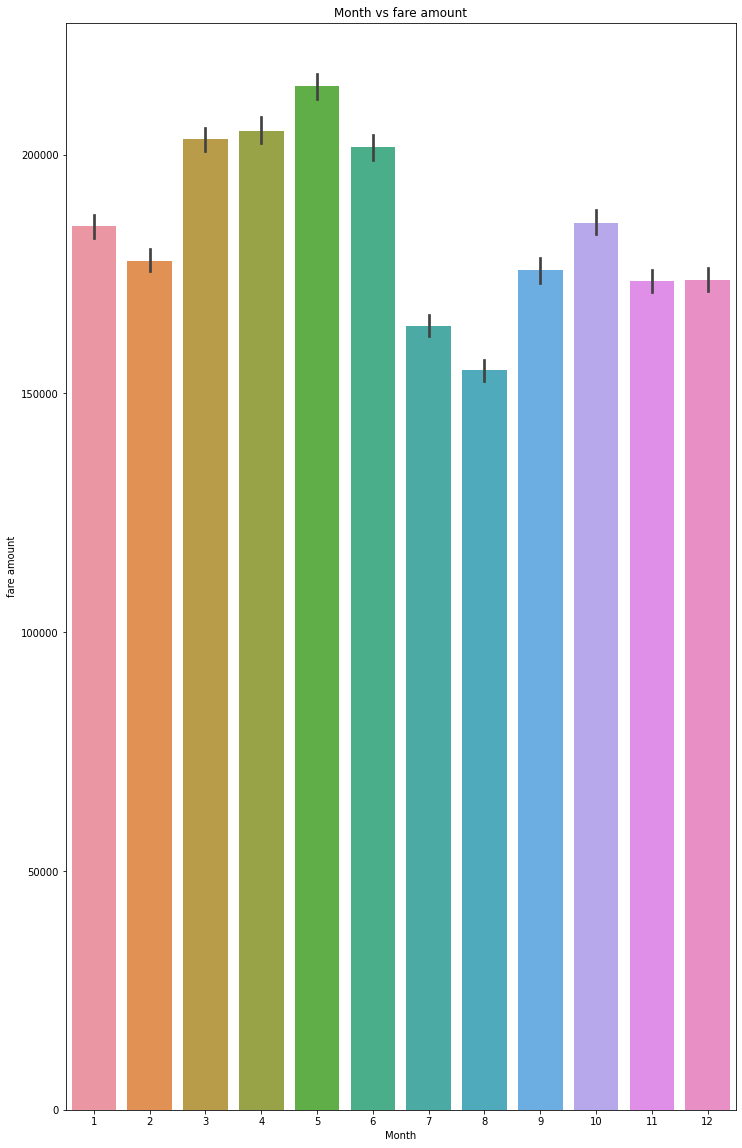

In [39]:
#month wise study 
plt.figure(figsize=(12,20))
plt.title('Month vs fare amount')
sb.barplot(x=uber_fare_df_1['pickup_month'],y=uber_fare_df_1['fare_amount'],estimator=sum)
plt.xlabel('Month')
plt.ylabel('fare amount')
plt.show()

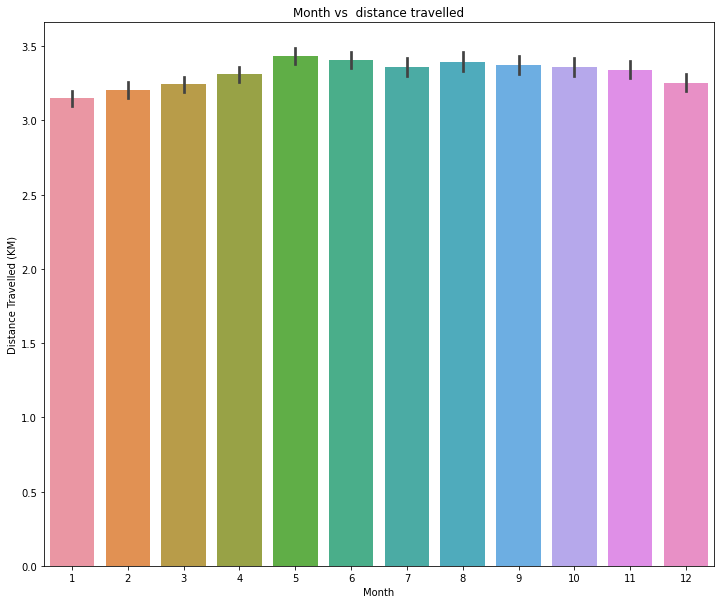

In [40]:
plt.figure(figsize=(12,10))
plt.title('Month vs  distance travelled')
sb.barplot(x=uber_fare_df_1['pickup_month'],y=uber_fare_df_1['distance_travelled (KM)'],estimator=np.mean)
plt.xlabel('Month')
plt.ylabel('Distance Travelled (KM)')
plt.show()

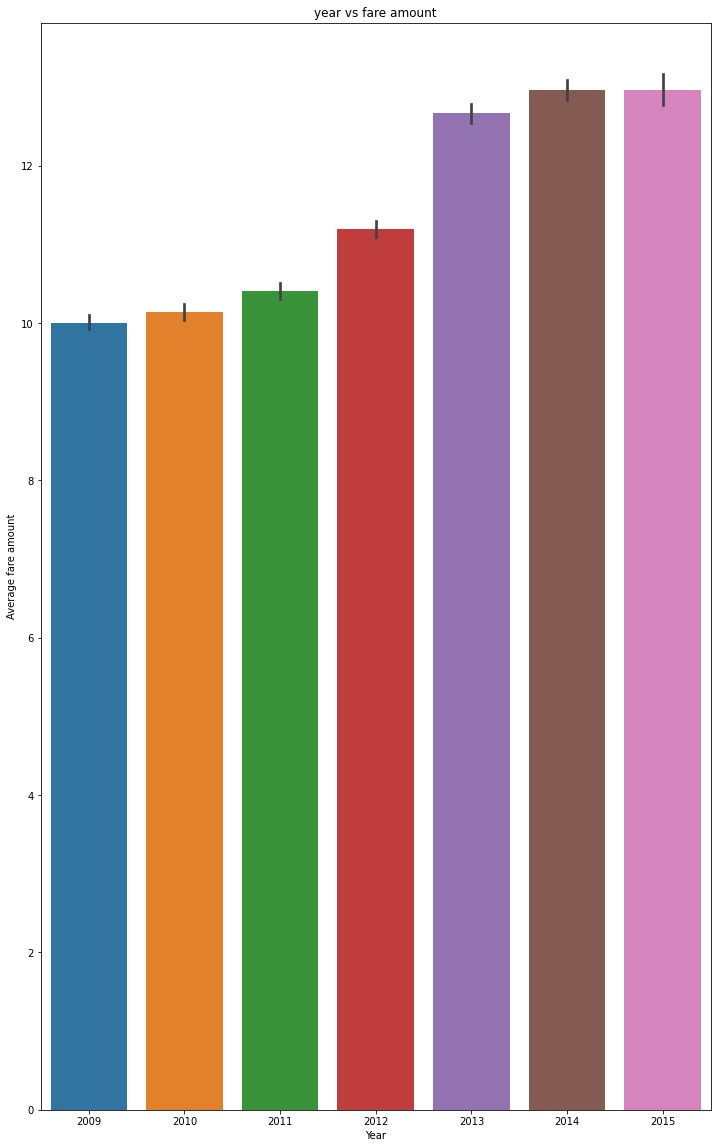

In [41]:
#year wise study 
plt.figure(figsize=(12,20))
plt.title('year vs fare amount')
sb.barplot(x=uber_fare_df_1['pickup_year'],y=uber_fare_df_1['fare_amount'])
plt.xlabel('Year')
plt.ylabel('Average fare amount')
plt.show()

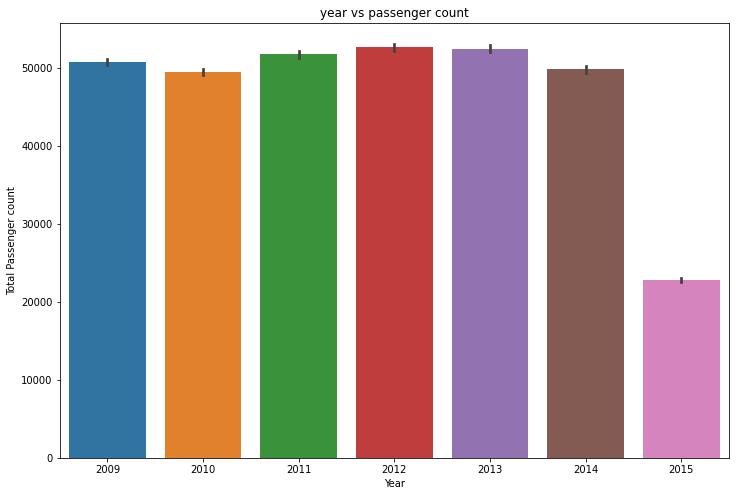

In [42]:
#year wise study 
plt.figure(figsize=(12,8))
plt.title('year vs passenger count')
sb.barplot(x=uber_fare_df_1['pickup_year'],y=uber_fare_df_1['passenger_count'],estimator=sum)
plt.xlabel('Year')
plt.ylabel('Total Passenger count')
plt.show()

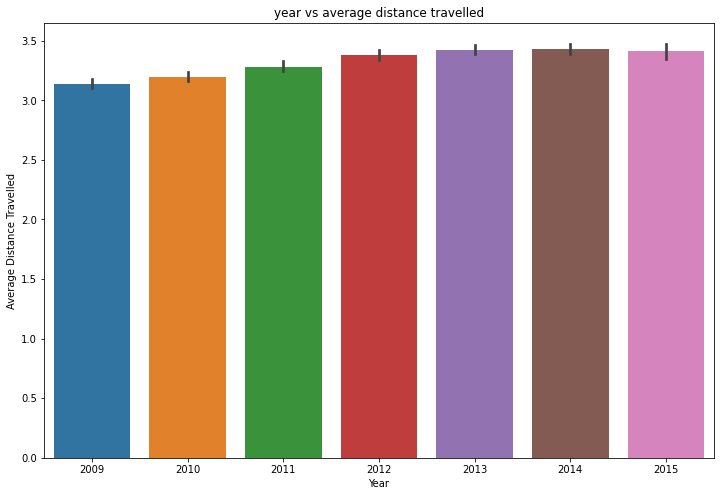

In [43]:
#year wise study 
plt.figure(figsize=(12,8))
plt.title('year vs average distance travelled')
sb.barplot(x=uber_fare_df_1['pickup_year'],y=uber_fare_df_1['distance_travelled (KM)'])
plt.xlabel('Year')
plt.ylabel('Average Distance Travelled')
plt.show()

#### Feature modification & Feature selection

In [44]:
uber_fare_df_1

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_timehour,Day,Day Part,pickup_month,pickup_year,distance_travelled (KM)
0,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,19,Thursday,Evening,5,2015,1.683323
1,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,20,Friday,Evening,7,2009,2.457590
2,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,21,Monday,Evening,8,2009,5.036377
3,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,8,Friday,Morning,6,2009,1.661683
4,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,17,Thursday,Afternoon,8,2014,4.475450
...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,3.0,2012-10-28 10:49:00+00:00,-73.987042,40.739367,-73.986525,40.740297,1,10,Sunday,Morning,10,2012,0.112210
199996,7.5,2014-03-14 01:09:00+00:00,-73.984722,40.736837,-74.006672,40.739620,1,1,Friday,Night,3,2014,1.875050
199997,30.9,2009-06-29 00:42:00+00:00,-73.986017,40.756487,-73.858957,40.692588,2,0,Monday,Night,6,2009,12.850319
199998,14.5,2015-05-20 14:56:25+00:00,-73.997124,40.725452,-73.983215,40.695415,1,14,Wednesday,Afternoon,5,2015,3.539715


In [45]:
uber_df_2= uber_fare_df_1.copy()

In [46]:
X= uber_fare_df_1.drop(['pickup_datetime','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','pickup_timehour','fare_amount'],axis=1)
y = uber_fare_df_1['fare_amount']

In [47]:
df_temp= pd.get_dummies(uber_fare_df_1[['Day','Day Part']],drop_first=True)
uber_fare_df_1 = pd.concat([uber_fare_df_1,df_temp],axis=1)
uber_fare_df_1

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_timehour,Day,Day Part,...,distance_travelled (KM),Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday,Day Part_Evening,Day Part_Morning,Day Part_Night
0,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,19,Thursday,Evening,...,1.683323,0,0,0,1,0,0,1,0,0
1,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,20,Friday,Evening,...,2.457590,0,0,0,0,0,0,1,0,0
2,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,21,Monday,Evening,...,5.036377,1,0,0,0,0,0,1,0,0
3,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,8,Friday,Morning,...,1.661683,0,0,0,0,0,0,0,1,0
4,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,17,Thursday,Afternoon,...,4.475450,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,3.0,2012-10-28 10:49:00+00:00,-73.987042,40.739367,-73.986525,40.740297,1,10,Sunday,Morning,...,0.112210,0,0,1,0,0,0,0,1,0
199996,7.5,2014-03-14 01:09:00+00:00,-73.984722,40.736837,-74.006672,40.739620,1,1,Friday,Night,...,1.875050,0,0,0,0,0,0,0,0,1
199997,30.9,2009-06-29 00:42:00+00:00,-73.986017,40.756487,-73.858957,40.692588,2,0,Monday,Night,...,12.850319,1,0,0,0,0,0,0,0,1
199998,14.5,2015-05-20 14:56:25+00:00,-73.997124,40.725452,-73.983215,40.695415,1,14,Wednesday,Afternoon,...,3.539715,0,0,0,0,0,1,0,0,0


In [48]:
uber_fare_df_1.drop(['Day','Day Part'],axis=1,inplace=True)

In [49]:
X= uber_fare_df_1.drop(['pickup_datetime','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','pickup_timehour','fare_amount'],axis=1)
y = uber_fare_df_1['fare_amount']
X_1=X.copy()


In [50]:
def vif_creation(X):
    vif_df= pd.DataFrame()
    vif_df['Feature Name'] = X.columns
    vif_df['Vif Factor']= [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
    return vif_df

vif_df= vif_creation(X_1)
vif_df

,Feature Name,Vif Factor
0,passenger_count,2.683303
1,pickup_month,4.338310
2,pickup_year,15.469962
3,distance_travelled (KM),1.860976
4,Day_Monday,1.820472
5,Day_Saturday,1.989928
6,Day_Sunday,1.867957
7,Day_Thursday,1.973527
8,Day_Tuesday,1.914514
9,Day_Wednesday,1.940982


In [51]:
X_1.drop(['pickup_year','pickup_month'],axis=1,inplace=True)
vif_df=vif_creation(X_1)
vif_df

,Feature Name,Vif Factor
0,passenger_count,2.321785
1,distance_travelled (KM),1.743921
2,Day_Monday,1.373170
3,Day_Saturday,1.476097
4,Day_Sunday,1.419891
5,Day_Thursday,1.455754
6,Day_Tuesday,1.416736
7,Day_Wednesday,1.431394
8,Day Part_Evening,1.656385
9,Day Part_Morning,1.805066


In [52]:
X.skew(axis=0)

passenger_count            1.980725
pickup_month               0.107955
pickup_year                0.061436
distance_travelled (KM)    2.945248
Day_Monday                 2.253445
Day_Saturday               1.945656
Day_Sunday                 2.171049
Day_Thursday               1.958010
Day_Tuesday                2.066908
Day_Wednesday              2.016853
Day Part_Evening           1.221164
Day Part_Morning           0.870902
Day Part_Night             1.329978
dtype: float64

In [53]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()

In [54]:
from sklearn.model_selection import train_test_split
#X_1=sm.add_constant(X_1)
X_train,X_test,y_train,y_test= train_test_split(X_1,y,test_size=0.3,random_state=100)
X_train['distance_travelled (KM)']=scaler.fit_transform(X_train['distance_travelled (KM)'].values.reshape(-1,1))
X_test['distance_travelled (KM)'] = scaler.transform(X_test['distance_travelled (KM)'].values.reshape(-1,1))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [55]:
X_train.describe()

,passenger_count,distance_travelled (KM),Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday,Day Part_Evening,Day Part_Morning,Day Part_Night
count,136646.000000,136646.000000,136646.000000,136646.000000,136646.000000,136646.000000,136646.000000,136646.000000,136646.000000,136646.000000,136646.000000
mean,1.690997,0.068195,0.125426,0.151918,0.131537,0.150506,0.141029,0.144834,0.239422,0.300689,0.223014
std,1.307087,0.073951,0.331203,0.358943,0.337988,0.357568,0.348052,0.351935,0.426732,0.458559,0.416269
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.025808,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.044332,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,0.080301,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Linear Regression Model

In [56]:
##model building 
from sklearn.linear_model import LinearRegression
lr_model= LinearRegression()
lr_model.fit(X_train,y_train)

LinearRegression()

In [57]:
print(f'The train accurcay of linear regression model is {lr_model.score(X_train,y_train)} and test score is {lr_model.score(X_test,y_test)}')

The train accurcay of linear regression model is 0.7233943738807849 and test score is 0.7570552240821654


In [58]:
#model seems to be good but preents overfitting.But needs to be improved

### KNN 

In [59]:
X_2= X.copy()

X_2.drop(['pickup_year','pickup_month','passenger_count'],axis=1,inplace=True)

In [60]:
vif_creation(X_2)

,Feature Name,Vif Factor
0,distance_travelled (KM),1.723150
1,Day_Monday,1.307179
2,Day_Saturday,1.377700
3,Day_Sunday,1.337157
4,Day_Thursday,1.379269
5,Day_Tuesday,1.343517
6,Day_Wednesday,1.357944
7,Day Part_Evening,1.594953
8,Day Part_Morning,1.747488
9,Day Part_Night,1.596603


In [61]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test= train_test_split(X_2,y,test_size=0.3,random_state=100)

In [62]:
scaler= MinMaxScaler()
X_train['distance_travelled (KM)']=scaler.fit_transform(X_train['distance_travelled (KM)'].values.reshape(-1,1))
X_test['distance_travelled (KM)'] = scaler.transform(X_test['distance_travelled (KM)'].values.reshape(-1,1))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [63]:
from sklearn.neighbors import KNeighborsRegressor
knn_model= KNeighborsRegressor()
knn_model.fit(X_train,y_train)
print(f'The train accurcay of KNN model is {knn_model.score(X_train,y_train)} and test score is {knn_model.score(X_test,y_test)}')

The train accurcay of KNN model is 0.7918612324566131 and test score is 0.7347595271722538


In [64]:
### based on default parameters, knn model is fine but is little overfitting

In [65]:
from sklearn.model_selection import RandomizedSearchCV
params = {'n_neighbors':[50,100,150,200,250,300],'weights':['uniform', 'distance'],'metric':['euclidean','minkowski']}
grid_model_knn= RandomizedSearchCV(estimator=knn_model,param_distributions=params,cv=5,scoring='r2',return_train_score=True,n_jobs=-1)
grid_model_knn.fit(X_train,y_train)
    
    




RandomizedSearchCV(cv=5, estimator=KNeighborsRegressor(), n_jobs=-1,
                   param_distributions={'metric': ['euclidean', 'minkowski'],
                                        'n_neighbors': [50, 100, 150, 200, 250,
                                                        300],
                                        'weights': ['uniform', 'distance']},
                   return_train_score=True, scoring='r2')

In [66]:
grid_model_knn.best_params_

{'weights': 'uniform', 'n_neighbors': 100, 'metric': 'euclidean'}

In [67]:
grid_model_knn.best_score_

0.7331929349502031

In [68]:
#building the model with the above params
knn_model=KNeighborsRegressor(**grid_model_knn.best_params_)
knn_model.fit(X_train,y_train)
print(f'The train accurcay of KNN model is {knn_model.score(X_train,y_train)} and test score is {knn_model.score(X_test,y_test)}')

The train accurcay of KNN model is 0.7405555829255657 and test score is 0.7644292667204042


In [69]:
### KNN model seems to have almost simmilar accuracy to linear regression, but there is little increment in scores!

### Random Forest Regressor

In [70]:
#### study the data with using RandomForestRegressor
X= uber_df_2.drop(['pickup_datetime','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','pickup_timehour','fare_amount'],axis=1)
y =uber_df_2['fare_amount']

In [71]:
from sklearn.preprocessing import LabelEncoder
label_encoder= LabelEncoder()
X[['Day','Day Part']]= X[['Day','Day Part']].apply(label_encoder.fit_transform)

In [72]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.3,random_state=100)
sc_1= StandardScaler()
X_train['distance_travelled (KM)']= sc_1.fit_transform(X_train['distance_travelled (KM)'].values.reshape(-1,1))
X_test['distance_travelled (KM)']= sc_1.transform(X_test['distance_travelled (KM)'].values.reshape(-1,1))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [73]:
#studying with default parameters
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor(max_depth=3)
rf_reg.fit(X_train,y_train)

RandomForestRegressor(max_depth=3)

In [74]:
rf_reg.score(X_train,y_train)

0.7260667015958092

In [75]:
rf_reg.score(X_test,y_test)

0.7556328465952908

In [76]:
#let's study the model randomforestregressor using the n_estimators
from sklearn.model_selection import RandomizedSearchCV
rf_reg= RandomForestRegressor()
parameters= {'n_estimators':[i for i in range(100,1500,300)],'max_depth':[i for i in range(2,20,5)],'min_samples_split':[3,4,5,7,10,20],'min_samples_leaf':[10,20,30,40,50]}
n_folds=5
grid_model= RandomizedSearchCV(estimator=rf_reg,param_distributions=parameters,cv=n_folds,scoring='r2',return_train_score=True)
grid_model.fit(X_train,y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(),
                   param_distributions={'max_depth': [2, 7, 12, 17],
                                        'min_samples_leaf': [10, 20, 30, 40,
                                                             50],
                                        'min_samples_split': [3, 4, 5, 7, 10,
                                                              20],
                                        'n_estimators': [100, 400, 700, 1000,
                                                         1300]},
                   return_train_score=True, scoring='r2')

In [77]:
grid_model.best_params_

{'n_estimators': 100,
 'min_samples_split': 3,
 'min_samples_leaf': 10,
 'max_depth': 12}

In [78]:
grid_model.best_score_

0.7707842547469512

In [79]:
df_nestimators= pd.DataFrame(grid_model.cv_results_)

In [80]:
df_nestimators

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,23.482520,1.013024,0.355164,0.002680,100,3,10,12,"{'n_estimators': 100, 'min_samples_split': 3, ...",0.774692,...,0.770784,0.033557,1,0.808124,0.803560,0.802234,0.806239,0.823687,0.808769,0.007736
1,15.059767,0.097877,0.174905,0.002362,100,7,40,7,"{'n_estimators': 100, 'min_samples_split': 7, ...",0.770594,...,0.767084,0.031716,6,0.772272,0.768585,0.766272,0.771270,0.788758,0.773431,0.007946
2,15.234936,0.130955,0.175193,0.000868,100,10,50,7,"{'n_estimators': 100, 'min_samples_split': 10,...",0.770687,...,0.766316,0.032489,7,0.771220,0.767501,0.765096,0.769618,0.787668,0.772221,0.007993
3,27.848377,0.186322,0.517044,0.007434,100,5,10,17,"{'n_estimators': 100, 'min_samples_split': 5, ...",0.774227,...,0.770035,0.033223,2,0.816569,0.813850,0.811831,0.815612,0.833140,0.818200,0.007642
4,89.849948,0.526834,1.312870,0.010542,400,10,40,12,"{'n_estimators': 400, 'min_samples_split': 10,...",0.772483,...,0.769670,0.031842,4,0.781571,0.778038,0.775824,0.780282,0.798421,0.782827,0.008040
5,154.857090,0.246616,1.730361,0.005773,1000,7,30,7,"{'n_estimators': 1000, 'min_samples_split': 7,...",0.771372,...,0.767479,0.032325,5,0.774470,0.770440,0.768209,0.772834,0.790418,0.775274,0.007864
6,35.342692,0.216609,0.326413,0.001196,700,7,50,2,"{'n_estimators': 700, 'min_samples_split': 7, ...",0.698324,...,0.686464,0.035543,9,0.682985,0.679955,0.676577,0.683845,0.704939,0.685660,0.009972
7,244.841611,1.012130,3.946294,0.014801,1000,5,40,17,"{'n_estimators': 1000, 'min_samples_split': 5,...",0.772321,...,0.769714,0.031849,3,0.782760,0.779303,0.776960,0.781638,0.799637,0.784060,0.008040
8,35.093532,0.242400,0.330676,0.010409,700,4,20,2,"{'n_estimators': 700, 'min_samples_split': 4, ...",0.698362,...,0.686403,0.035478,10,0.683026,0.680015,0.676121,0.683948,0.704942,0.685610,0.010045
9,4.980615,0.046608,0.049542,0.001066,100,7,50,2,"{'n_estimators': 100, 'min_samples_split': 7, ...",0.697607,...,0.686620,0.035532,8,0.682369,0.680392,0.676893,0.684286,0.705193,0.685827,0.009987


In [81]:
### creating a model out of the obtained parameters
rf_reg = RandomForestRegressor(**grid_model.best_params_)
rf_reg.fit(X_train,y_train)

print(f'The test score of random forest regression model is {rf_reg.score(X_test,y_test)} and train score is {rf_reg.score(X_train,y_train)}')

The test score of random forest regression model is 0.7967878716011342 and train score is 0.8076526998278893


### From the above studies these are my findings,

#### 1. saw the improvement in accuracy when distance >50km is removed 

#### 2. For the linear regression model, The train accurcay of linear regression model is 0.7233943738807849 and test score is 0.7570552240821654.

#### 3. For KNN after Randomizedsearch, The train accurcay of KNN model is 0.7405555829255657 and test score is 0.7644292667204042

#### 4. For RandomForest Tree Regressor, he test score of random forest regression model is 0.7967878716011342 and train score is 0.8076526998278893



#### from these overall random forest tree regressor is having a good score with less/no overfitting.